# Race-Memory Project Analysis

### Load libraries, custom functions, and metadata

In [59]:
import math
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
import scipy.stats as sp
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from ast import literal_eval
from IPython.display import Markdown as md
import re, os
pd.options.mode.chained_assignment = None 
import warnings ; warnings.filterwarnings('ignore')
downloads_path = '/Users/chrisiyer/Downloads/'

In [60]:
###### import custom functions
import functions as fun
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
meta = fun.load_metadata() # load metadata just in case

### Load data

In [180]:
data_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/main/'
# files = [i for i in os.listdir(data_path) if i.startswith('taskdata')]
files = [
    'taskdata_chris_main_task_5_prolific_afc4_14_09_2022.csv',
    'taskdata_chris_main_task_5_prolific_afc5_12_09_2022.csv',
    'taskdata_chris_main_task_5_prolific_afc6_26_09_2022.csv'
]
df_list = []
for f in files:
    df_list.append(pd.read_csv(data_path + f))
df = pd.concat(df_list)

In [181]:
# fill in tilt_difference and tilt_change
for i in range(len(df)):
    if 'retrieval' in df.trial_type.iloc[i]:
        if pd.isna(df.tilt_difference.iloc[i]) and not pd.isna(df.old_tiltLR.iloc[i]) and not pd.isna(df.old_original_tiltLR.iloc[i]):
            tilt = fun.get_tilt_change(df.old_original_tiltLR.iloc[i], df.old_tiltLR.iloc[i])
            df['tilt_difference'].iloc[i] = tilt['difference']
            df['tilt_change'].iloc[i] = tilt['change'] 
if df[df.trial_type == 'retrieval'].tilt_difference.isna().sum() != 0:
    print('tilt difference incomplete')
else: print('all good!')
if df[df.trial_type == 'retrieval'].tilt_change.isna().sum() != 0:
    print('tilt change incomplete')
else: print('all good!')

all good!
all good!


In [182]:
# add 'tilted' boolean column
df['tilted'] = (df['tilt_difference'] != 0) & ( (df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice') )  
df.loc[(df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice'), 
       'response'] = pd.to_numeric(df.loc[(df['trial_type'] == 'retrieval') | 
                                          (df['trial_type'] == 'retrieval_practice'), 
                                          'response'])

In [183]:
df['iteration'] = df['iteration'].replace(['sona_af3'],'sona_afc3') # typo in one iteration

In [184]:
df_noexcludes = df.copy()

### Subject Exclusions

In [185]:
# 1. PROLIFIC GLITCH (subjects who confirmed glitch) from 'prolific_afc_50_subjects'
# one of these participants got like 70% on the retrieval trials they did. So maybe scrap the whole iteration?
prolific_glitch = [
    '5e68682ce3b2f71041fa03d2', 
    '610d170f7bb4e720cb85b6b2',
    '580bea98827ca10001db514e',
    '60ba71aa8f2ae12d3a595982'
]
prolific_glitch = [i for i in prolific_glitch if i in df.subject_id.unique()]
df = df[~df.subject_id.isin(prolific_glitch)]
print(str(len(prolific_glitch)) + ' PROLIFIC IDS EXCLUDED:', '\n', prolific_glitch)

0 PROLIFIC IDS EXCLUDED: 
 []


In [186]:
# 2. UNFINISHED EXPERIMENT (there are many b/c df contains data from a glitchy run)
# This includes 9 subjects from a glitchy run in pilot_prolific_afc2, 11+ others from elsewhere
# This is computed based on if there is a 'summary' trial or not
df = fun.exclude_nofinish(df) 

1 EXPERIMENT IDS EXCLUDED:
 ['ssovnp524s3w7qtwz87d']
[71]


In [187]:
# 4. SKIPPED - REPEATED INCORRECT PRACTICE TRIALS
# if they got max_wrong = 5 practice trials wrong in a row, excluded
# df = fun.exclude_practice(df, max_wrong = 5)

In [188]:
# 5. TIMEOUTS - subs who timed out on everything
df = fun.exclude_timeout(df)

0 EXPERIMENT IDS EXCLUDED:
 []


In [189]:
# 6. EXCLUDE SUBJECTS BY RETRIEVAL PERFORMANCE above chance? or what
df_raw = df.copy()
df = fun.exclude_chance_retrieval(df, alt = 'greater', p = 0.05, testing=False) # vs. 'two-sided' for t test

16 EXPERIMENT IDS EXCLUDED:
 ['bekm0cy9xqoaj3vlle58', 'dd6gu4wm7h6h7koncy4d', 'np6npu2tmtcgrbjx1qq9', 'qffkcd67p58jl3ccppm1', 'dw887uhy6dyhz6lny0b1', 's86ur5n7pvs9cfohl3gh', 'rorc6ba1apes6ufbzkvv', '7svbnvvr79safymrys8b', '33wow5gx0ly0bnt9d4x4', 'xdv9dya0lo4n6x1zr6cx', 'gku7u1uf9an86oxrhswm', 'qhy5m4smqvk1ldlwnmks', 'hnofuajabkh3hjqrm8gb', 'w9ru65dtx9y2pu600gzo', 'hr74naqu57otg8x8dssb', '51cuk02208bbp0hwonsq']


In [190]:
# 7. CHECK ITERATIONS
# 'pilot_prolific_afc', 'prolific_afc3', 'sona_afc3': these are the within-race AFC pairing iterations
# df = df[df.iteration.isin(['pilot_prolific_afc', 'prolific_afc3', 'sona_afc3'])]

### Remaining subject demographics

In [191]:
print('# of participants remaining:')
print(len(df.experiment_id.unique()))

print('Original number of subjects: ', len(df_noexcludes.experiment_id.unique()))

# of participants remaining:
13
Original number of subjects:  30


In [192]:
# 6. SEPARATE DF with just white-identifying subjects
df_white = df[df.experiment_id.isin(
    df[df.race == "['White']"].experiment_id.unique()
)]

print(len(df.experiment_id.unique()))
print(len(df_white.experiment_id.unique()))

13
12


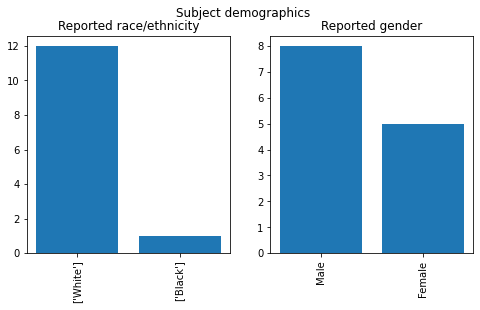

["['White']" "['Black']"]
[12, 1]
8 women, 5 men


In [193]:
fun.demographics_plot(df)

In [194]:
print('Age range: ' + str(df.age.min()) + " - " + str(df.age.max()))
print('Median age: ' + str(df.age.median()))

Age range: 21.0 - 51.0
Median age: 27.0


## Subject-Level

In [195]:
stats = fun.get_stats(df, only_correct_encoding = True, only_high_confidence = False)

In [196]:
stats_raw = fun.get_stats(df_raw, only_correct_encoding = True, only_high_confidence = False)

In [197]:
stats_orig = stats.copy()

In [204]:
stats = stats_raw

### ******MAIN SUMMARY******

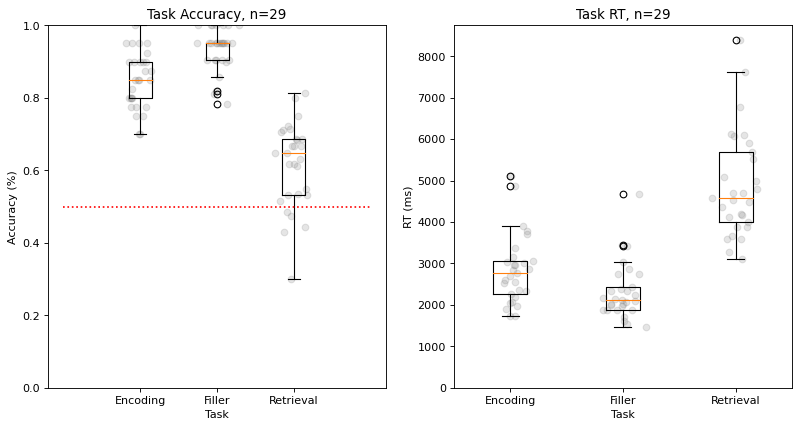

Population retrieval accuracy is significantly above chance:
Ttest_1sampResult(statistic=5.244384408443513, pvalue=1.4221568375639961e-05)


In [205]:
fun.summary_plot(stats)
print('Population retrieval accuracy is significantly above chance:')
print(sp.ttest_1samp(stats.ret_acc, popmean = 0.5))

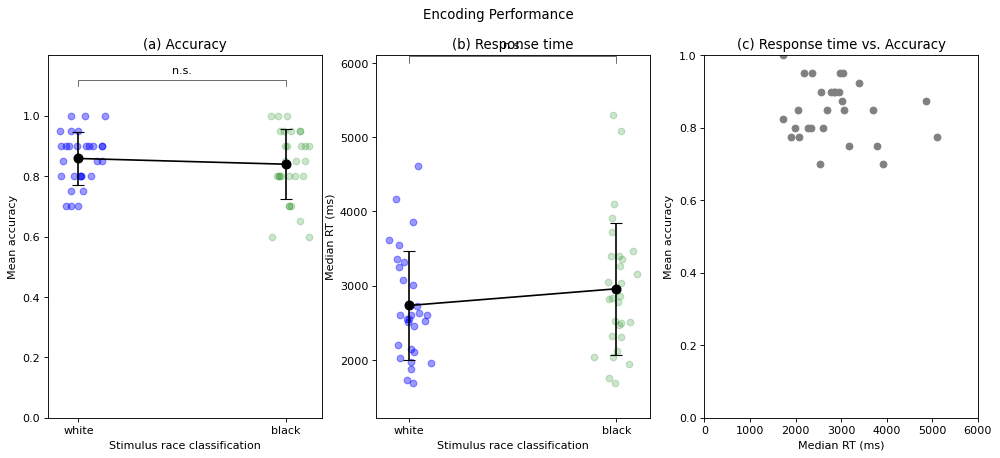

In [206]:
fun.encoding_plots(stats, save=False)

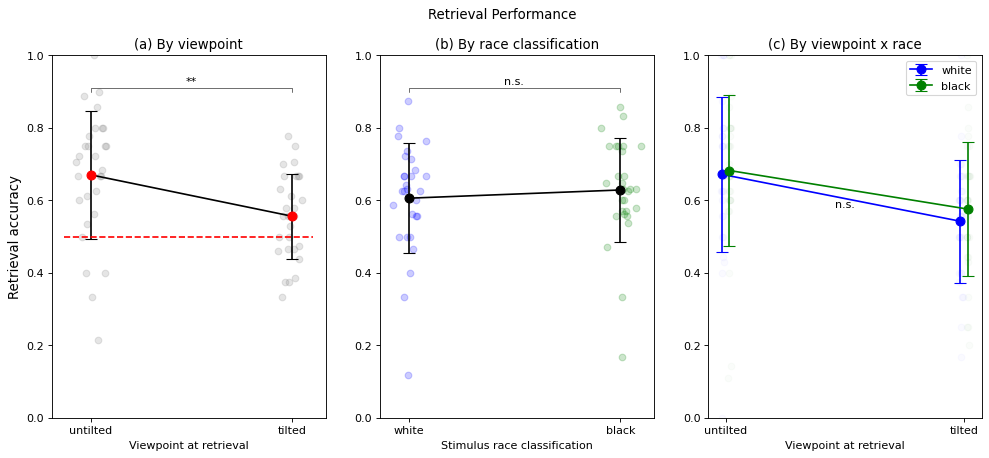

In [207]:
fun.retrieval_plots(stats, save=False)

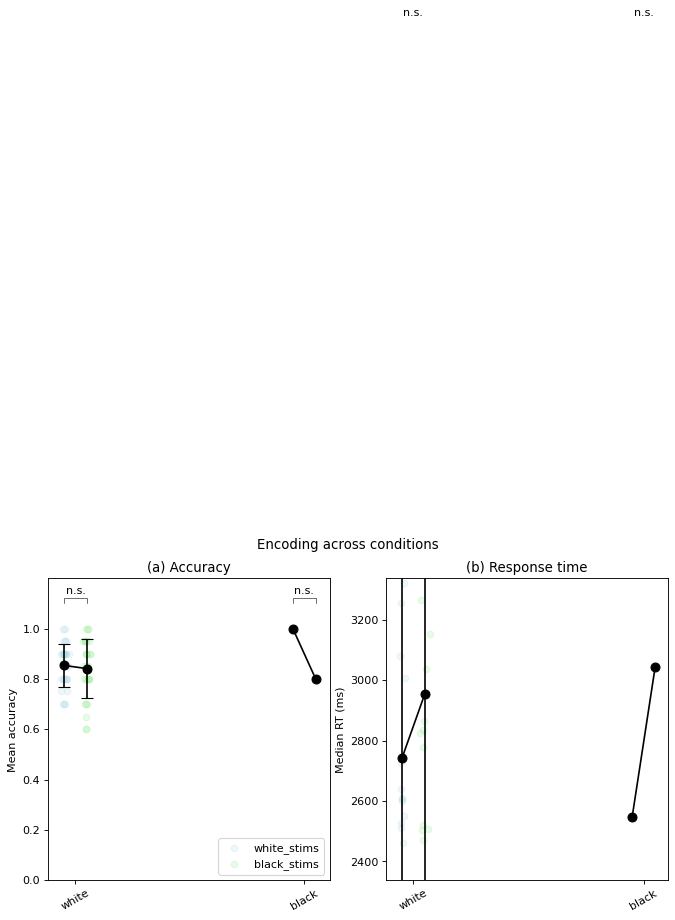

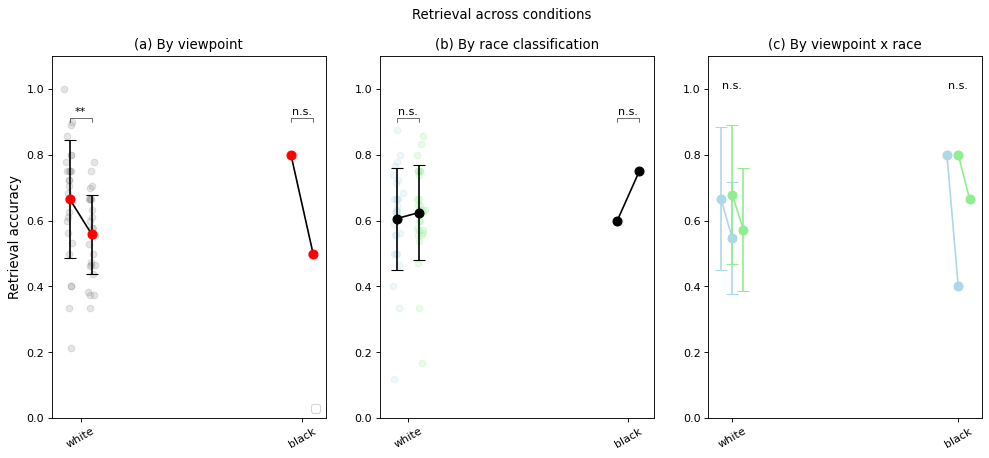

In [208]:
data_wb = {
    'white': stats[stats.race.str.contains('White')],
    'black': stats[stats.race.str.contains('Black')]
}
fun.compare_versions(data_wb)

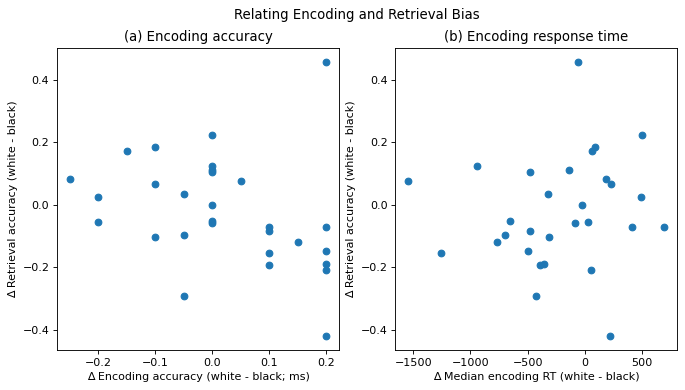

In [209]:
fun.encoding_delta_plot(stats, save = False)
#plt.scatter(stats.enc_rt_delta, stats.ret_acc_w_0-stats.ret_acc_b_0)

In [210]:
fun.results(stats)


--Encoding--
 - accuracy by race (Wilcoxon):
WilcoxonResult(statistic=98.5, pvalue=0.3613295670576375)
 - RT by race (Wilcoxon):
WilcoxonResult(statistic=127.0, pvalue=0.050359261177925704)
 - RT vs. accuracy (OLS):
LinregressResult(slope=-1.5886499851773305e-05, intercept=0.8942794203632967, rvalue=-0.16747190755066688, pvalue=0.38520301921241384, stderr=1.7998115808961436e-05, intercept_stderr=0.05321556441731046)

--Retrieval--
 - accuracy by tilt (Wilcoxon):
WilcoxonResult(statistic=74.0, pvalue=0.0033065251185283836)
 - accuracy by race (Wilcoxon):
WilcoxonResult(statistic=168.0, pvalue=0.42543613472442965)
 - dist by race (Wilcoxon):
WilcoxonResult(statistic=194.0, pvalue=0.6113514993496755)
 - accuracy by tilt * race (OLS):
$\beta = -0.02$, $F(3, 112)$ = $-0.32, P = 0.752 $

--Encoding-Retrieval--
 - ∆enc_rt vs ∆ret_acc (OLS):
LinregressResult(slope=4.209828349107038e-05, intercept=-0.01325799072793783, rvalue=0.1256922379101441, pvalue=0.5158963816301343, stderr=6.394639268042

### MORE IN DEPTH

### 1. Encoding

Encoding performance by tilt metrics

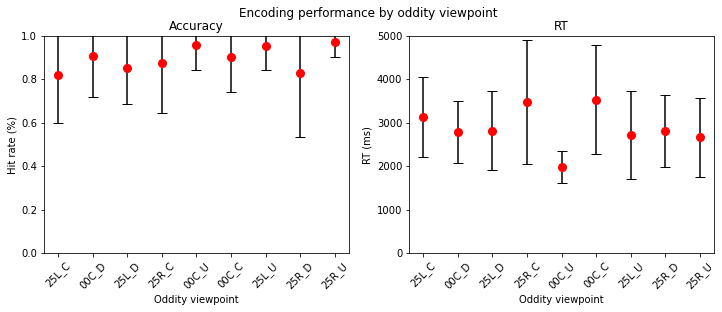

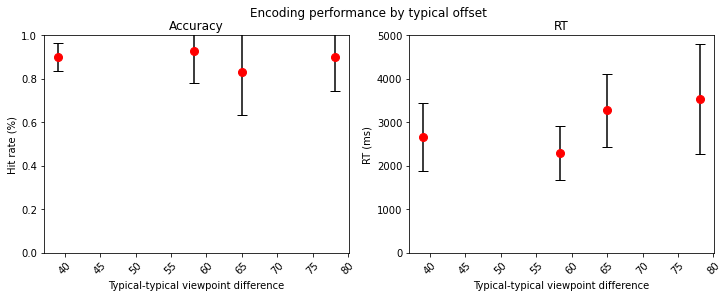

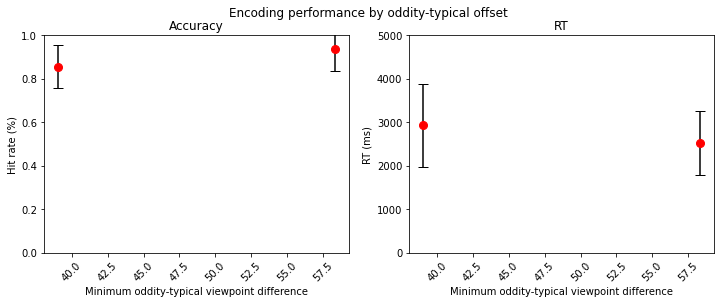

In [86]:
fun.encoding_view_plots(df)

### 2. Filler

accuracy and RT by category

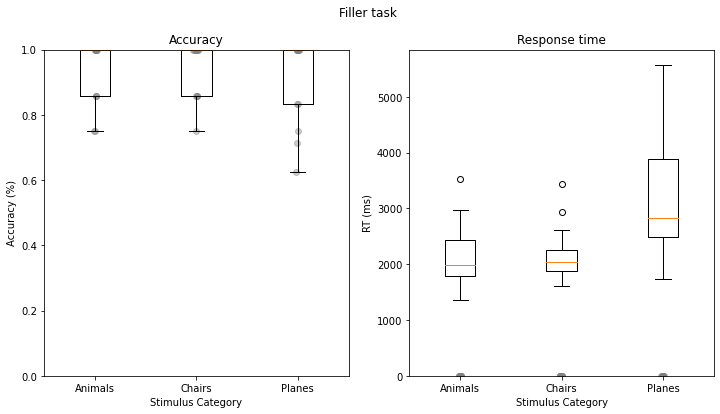

In [87]:
fun.filler_plot(stats)

encoding-retrieval delay vs. mean retrieval accuracy per subject

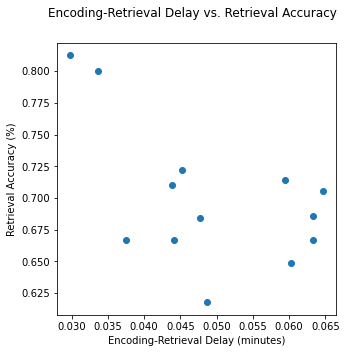

LinregressResult(slope=-0.04189285721714747, intercept=0.8241932405846937, rvalue=-0.5406839018679681, pvalue=0.056412289446435435, stderr=0.01965227377065429, intercept_stderr=0.05974105574384345)


In [88]:
fun.filler_delay_plot(stats[stats.enc_ret_delay/60 < 1]) # 2 outliers excluded, < 0.2 for 4 outliers excluded
print(sp.linregress(x=stats.enc_ret_delay, y=stats.ret_acc))

Filler performance predicted by encoding performance

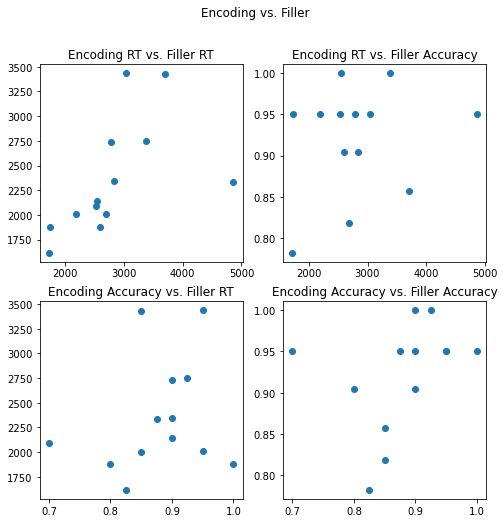

LinregressResult(slope=0.3822672541847468, intercept=1282.485546181798, rvalue=0.5527721522876266, pvalue=0.05008543219839013, stderr=0.17375722997282037, intercept_stderr=508.5004872724531)
LinregressResult(slope=1.7031372050859078e-05, intercept=0.8726316270516555, rvalue=0.21583641313583002, pvalue=0.47881285318020506, stderr=2.3231084653498978e-05, intercept_stderr=0.06798576305584329)
LinregressResult(slope=1696.1299052774016, intercept=867.9012178619757, rvalue=0.22655601968723116, pvalue=0.4566866673266642, stderr=2198.595267526763, intercept_stderr=1939.0520135268084)
LinregressResult(slope=0.30214422866067275, intercept=0.6550353360040363, rvalue=0.3536932874533287, pvalue=0.2357897448645351, stderr=0.24091875700355847, intercept_stderr=0.21247839825910084)


In [89]:
fun.encoding_filler_plot(stats)
print(sp.linregress(x=stats.enc_rt, y=stats.fil_rt))
print(sp.linregress(x=stats.enc_rt, y=stats.fil_acc))
print(sp.linregress(x=stats.enc_acc, y=stats.fil_rt))
print(sp.linregress(x=stats.enc_acc, y=stats.fil_acc))

### 3. Retrieval

Distribution of slider responses

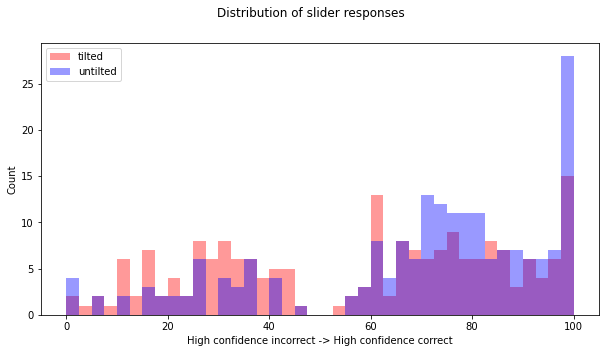

In [90]:
fun.slider_response_plot(df)

Confidence by tilt for hit trials

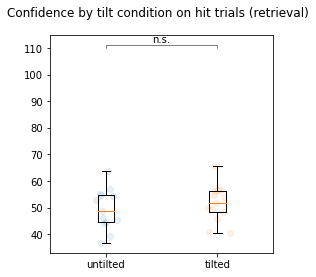

WilcoxonResult(statistic=26.0, pvalue=0.19091796875)


In [91]:
fun.hits_confidence_by_tilt_plot(df)

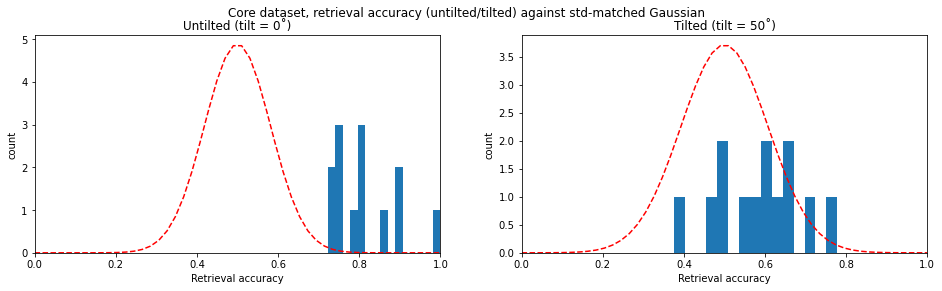

In [85]:
fun.tilt_chance_hist(stats)

retrieval accuracy black vs. white

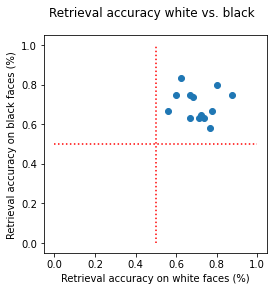

In [92]:
fun.retrieval_race_scatter_plot(stats)

Serial position at encoding vs. average retrieval accuracy (for recency/primacy effects?)

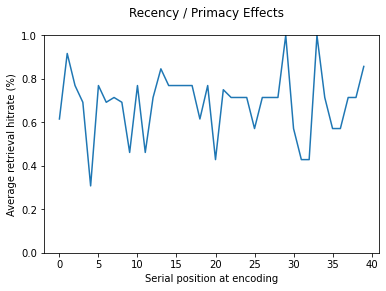

In [93]:
# serial position
fun.serial_position_plot(df)

Retrieval performance predicted by encoding performance

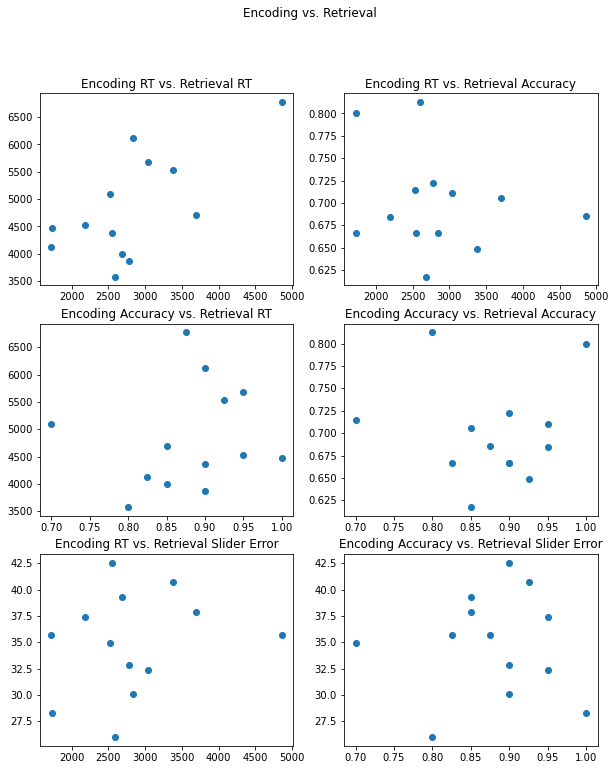

LinregressResult(slope=0.755379729626001, intercept=2708.8064749162418, rvalue=0.6623034381414831, pvalue=0.013646325613034752, stderr=0.25765017717489325, intercept_stderr=754.0131749324094)
None
LinregressResult(slope=-1.482274771185231e-05, intercept=0.7418508272698742, rvalue=-0.22327182820061958, pvalue=0.46341266370494816, stderr=1.951167086526057e-05, intercept_stderr=0.057100899594432465)
None
LinregressResult(slope=1913.7320705373163, intercept=3153.2662379966296, rvalue=0.15499234662792685, pvalue=0.6131389341632658, stderr=3677.853390849498, intercept_stderr=3243.684332590017)
None
LinregressResult(slope=0.014934614166066708, intercept=0.6870007044533483, rvalue=0.020779574699816544, pvalue=0.9462801312035323, stderr=0.21665425740423339, intercept_stderr=0.19107831271347006)
None
LinregressResult(slope=0.0013317215263179225, intercept=31.163889281076692, rvalue=0.22740634089215422, pvalue=0.45495290991502235, stderr=0.0017194290427381784, intercept_stderr=5.03190863597179)
N

In [94]:
fun.encoding_retrieval_plot(stats)
print(fun.linregna(x=stats.enc_rt, y=stats.ret_rt))
print(fun.linregna(x=stats.enc_rt, y=stats.ret_acc))
print(fun.linregna(x=stats.enc_acc, y=stats.ret_rt))
print(fun.linregna(x=stats.enc_acc, y=stats.ret_acc))
print(fun.linregna(x=stats.enc_rt, y=stats.ret_dist))
print(fun.linregna(x=stats.enc_acc, y=stats.ret_dist))

Retrieval accuracy by tilt shown at encoding

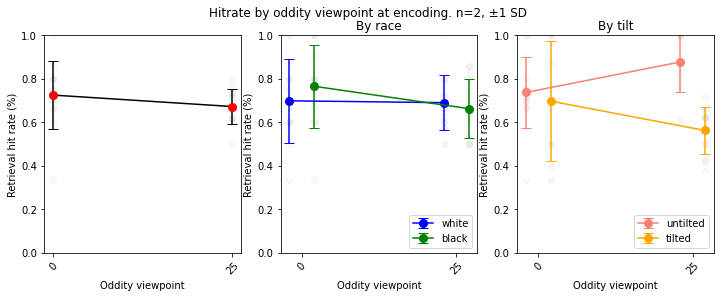

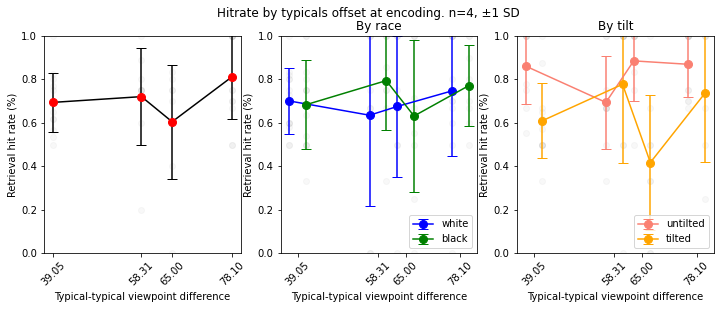

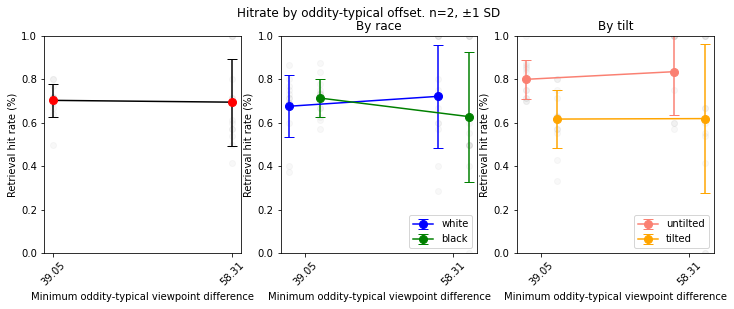

In [95]:
# 3 measures of encoding tilt on retrieval performance:
# 1. Oddity viewpoint (symmetrical)
# 2. Typical-typical offset
# 3. Oddity-typical offset (min)

fun.encoding_tilt_plots(df)

In [96]:
fun.show_model_parameters(smf.ols("accuracy ~ enc_tilt * ret_tilt", data = {
        'accuracy': np.concatenate([stats.ret_acc_0_enc_00C, 
                                    np.nanmean([stats.ret_acc_0_enc_25R, stats.ret_acc_0_enc_25L],axis=0), 
                                    np.nanmean([stats.ret_acc_0_enc_50R, stats.ret_acc_0_enc_50L],axis=0),
                                    stats.ret_acc_50_enc_00C, 
                                    np.nanmean([stats.ret_acc_50_enc_25R, stats.ret_acc_50_enc_25L],axis=0), 
                                    np.nanmean([stats.ret_acc_50_enc_50R, stats.ret_acc_50_enc_50L],axis=0),
                                    ]), 
    
        'ret_tilt': np.concatenate([np.repeat(0, 3*len(stats)), np.repeat(1, 3*len(stats))]),
        'enc_tilt': np.concatenate([np.repeat(0, len(stats)), np.repeat(1, len(stats)), np.repeat(2, len(stats)), 
                                    np.repeat(0, len(stats)), np.repeat(1, len(stats)), np.repeat(2, len(stats))])
        }))

AttributeError: 'DataFrame' object has no attribute 'ret_acc_0_enc_50R'

### Key retrieval analyses


**1. Retrieval bias predicted by encoding bias**

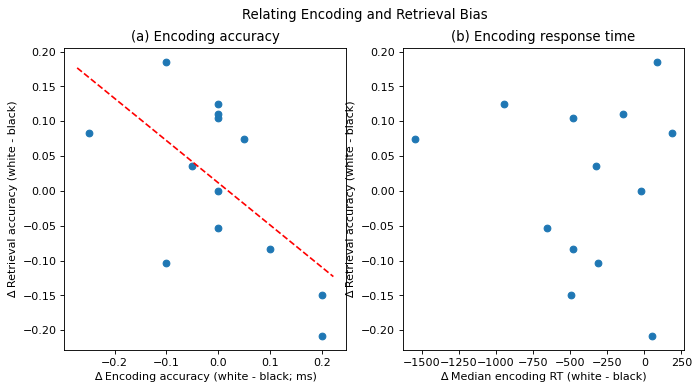

LinregressResult(slope=-2.318989377004296e-05, intercept=0.00028679504911427803, rvalue=-0.09166372194136173, pvalue=0.765837507556117, stderr=7.595785605824289e-05, intercept_stderr=0.04559954654908093)
None
LinregressResult(slope=-0.6051620347495852, intercept=0.011683373638681799, rvalue=-0.6133444973782697, pvalue=0.025792637510910755, stderr=0.2349613950983061, intercept_stderr=0.027455162258897773)
None
LinregressResult(slope=-0.004354641979330334, intercept=-4.343648411740158, rvalue=-0.1840216610751221, pvalue=0.5472930110411018, stderr=0.007013039817035708, intercept_stderr=4.210116664460203)
None
LinregressResult(slope=73.13238220279548, intercept=-2.9219268184497245, rvalue=0.7924288573102806, pvalue=0.001237700615183267, stderr=16.972958403198493, intercept_stderr=1.9832846446045662)
None


In [98]:
fun.encoding_delta_plot(stats, save=False, slider=False)
# fun.encoding_delta_plot(stats, slider=True)
print(fun.linregna(x=stats.enc_rt_delta, y=stats.ret_acc_delta))
print(fun.linregna(x=stats.enc_acc_delta, y=stats.ret_acc_delta))
print(fun.linregna(x=stats.enc_rt_delta, y=stats.ret_dist_delta))
print(fun.linregna(x=stats.enc_acc_delta, y=stats.ret_dist_delta))

In [99]:
smf.mixedlm("ret_acc_delta ~ enc_rt_delta", data = {
    "ret_acc_delta": stats.ret_acc_delta,
    "enc_rt_delta": stats.enc_rt_delta
    }, groups = stats['experiment_id'],
            #re_formula = "~enc_rt_delta"
           ).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: ret_acc_delta
No. Observations: 13      Method:             REML         
No. Groups:       13      Scale:              0.0078       
Min. group size:  1       Log-Likelihood:     -1.3978      
Max. group size:  1       Converged:          Yes          
Mean group size:  1.0                                      
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.000    0.006  0.045 0.964 -0.012  0.013
enc_rt_delta     -0.000    0.000 -0.463 0.643 -0.000  0.000
Group Var         0.008                                    
===========================================================

"""

are residuals greater than 0? of course they are

**2. Retrieval accuracy by tilt and race**

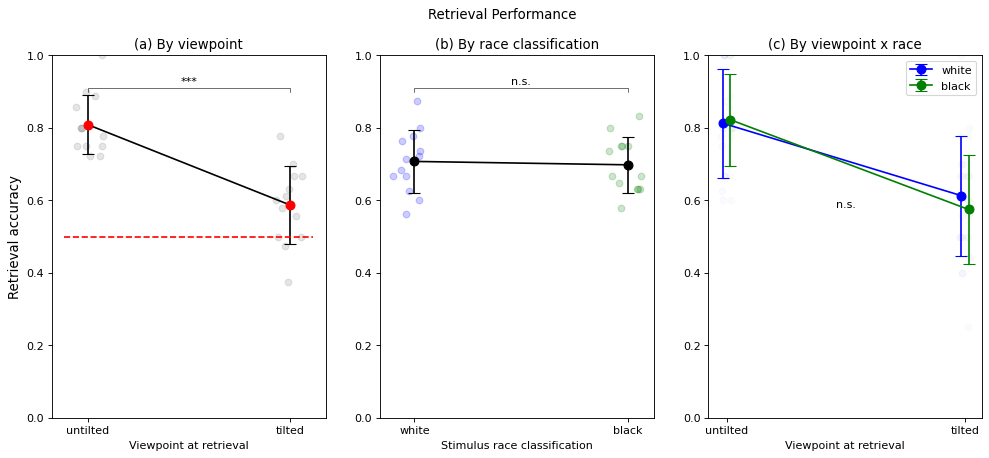

In [100]:
fun.retrieval_plots(stats, save=False)

**3. Retrieval accuracy by encoding median RT split**

In [101]:
stats_enc_split = fun.get_encoding_split_stats(df, only_correct_encoding = True, only_high_confidence = False)

In [102]:
stats_enc_split

,experiment_id,enc_acc_high,enc_acc_low,enc_acc_delta,enc_rt_high,enc_rt_low,enc_rt_delta,ret_acc_high,ret_acc_low,ret_acc_delta,...,ret_acc_low_0,ret_acc_high_50,ret_acc_low_50,ret_dist_high,ret_dist_low,ret_dist_delta,ret_dist_high_0,ret_dist_low_0,ret_dist_high_50,ret_dist_low_50
0,3ywjuoa2bgcqfcvotmhb,0.90,1.00,-0.10,3781.0,2214.5,1566.5,0.833333,0.600000,0.233333,...,0.555556,0.714286,0.636364,27.333333,37.210526,-9.877193,22.909091,40.125000,34.285714,35.090909
1,7a2np84h5a28jb82evfd,0.90,0.90,0.00,3395.0,1869.0,1526.0,0.666667,0.666667,0.000000,...,0.750000,0.625000,0.600000,43.777778,41.333333,2.444444,42.600000,36.875000,45.250000,44.900000
2,rh7q2bs50k3ewfjomzno,0.90,1.00,-0.10,3588.5,1906.5,1682.0,0.777778,0.600000,0.177778,...,0.600000,0.600000,0.600000,30.055556,44.050000,-13.994444,20.750000,50.600000,37.500000,37.500000
3,bvqww4r2dnwa1glf7o1f,0.90,0.85,0.05,6817.5,3028.5,3789.0,0.555556,0.823529,-0.267974,...,0.857143,0.444444,0.800000,50.058824,20.500000,29.558824,41.625000,12.333333,57.555556,25.400000
4,0f4hrrw5qvra868ed1qq,0.85,1.00,-0.15,4628.0,2178.0,2450.0,0.705882,0.600000,0.105882,...,0.750000,0.714286,0.500000,38.117647,43.105263,-4.987616,36.800000,38.250000,40.000000,46.636364
5,p4nuvm7a6lsn9fw3ekz0,0.80,0.90,-0.10,3673.0,2247.5,1425.5,0.625000,0.611111,0.013889,...,0.800000,0.333333,0.538462,39.875000,38.722222,1.152778,27.200000,21.000000,61.000000,45.538462
6,0n04ntnvxab7kcwfs0lb,0.85,0.80,0.05,2214.0,1521.5,692.5,0.588235,0.750000,-0.161765,...,0.833333,0.375000,0.700000,39.823529,31.375000,8.448529,29.111111,22.833333,51.875000,36.500000
7,26o7jq95u69cmyl7q3tt,0.90,0.90,0.00,3800.5,2141.5,1659.0,0.666667,0.777778,-0.111111,...,1.000000,0.400000,0.333333,33.111111,32.666667,0.444444,13.000000,20.166667,49.200000,57.666667
8,vdt8vfwl626ubga1m7oa,0.50,0.90,-0.40,3257.0,2229.5,1027.5,0.800000,0.666667,0.133333,...,0.666667,0.666667,0.666667,30.000000,37.666667,-7.666667,10.500000,36.833333,43.000000,39.333333
9,gqqm0cphh2td9md7jhxw,1.00,1.00,0.00,2093.5,1518.0,575.5,0.900000,0.700000,0.200000,...,0.833333,0.833333,0.500000,27.000000,29.500000,-2.500000,23.750000,18.166667,29.166667,46.500000


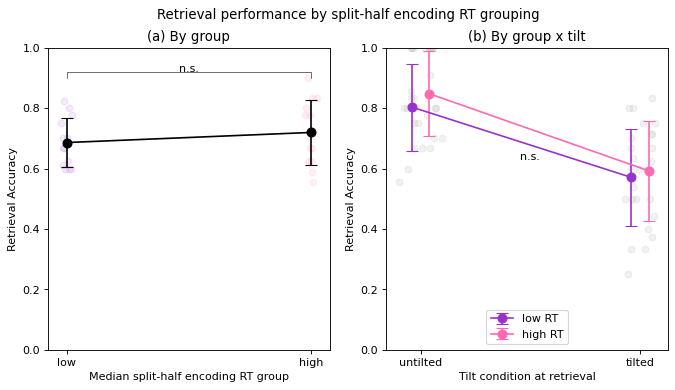

Test for panel A: 
 WilcoxonResult(statistic=28.0, pvalue=0.38818640520827785)
Test for panel B: 
 $\beta = -0.02$, $F(3, 48)$ = $-0.27, P = 0.792 $


In [103]:
fun.retrieval_split_plot(stats_enc_split)

so how do we account for the paradoxical findings in retrieval performance?

## Item-Level Analysis

We can obtain for each face 1) avg encoding accuracy (when this face is oddity), 2) avg encoding RT, and 3) avg retrieval accuracy, and relate these measures to each other, to the classification judgements, and to stimulus attributes

In [104]:
stats_byface = fun.get_stats_byface(df, only_correct_encoding = True)

In [105]:
stats_byface

,identity,race,gender,enc_rt,enc_acc,ret_rt,ret_acc,ret_rt_0,ret_acc_0,ret_rt_50,ret_acc_50,ret_dist,ret_dist_0,ret_dist_50,mb
0,054,white,woman,3117.0,0.666667,3963.75,0.5,4728.0,1.0,3199.5,0.0,36.000000,0.0,72.000000,0.830090
1,020,black,woman,3966.0,0.333333,5932.00,1.0,5932.0,1.0,NaN,NaN,31.000000,31.0,NaN,0.808698
2,103,black,woman,2387.0,1.000000,4674.00,1.0,NaN,NaN,4674.0,1.0,13.400000,NaN,13.400000,0.832389
3,021,black,man,2894.5,0.750000,4696.00,1.0,5092.5,1.0,3216.0,1.0,20.333333,30.5,0.000000,0.821749
4,148,white,woman,2992.0,1.000000,4736.50,1.0,4639.0,1.0,4834.0,1.0,18.500000,15.0,19.666667,0.836120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,126,black,woman,4473.5,0.500000,6536.20,1.0,6536.2,1.0,NaN,NaN,32.000000,32.0,NaN,0.817517
115,060,black,woman,3122.5,0.500000,3625.60,0.0,3625.6,0.0,NaN,NaN,74.000000,74.0,NaN,0.828456
116,090,black,man,2115.0,1.000000,4600.00,1.0,4600.0,1.0,NaN,NaN,27.000000,27.0,NaN,0.820820
117,068,black,woman,2608.0,1.000000,5530.00,1.0,NaN,NaN,5530.0,1.0,43.000000,NaN,43.000000,0.822705


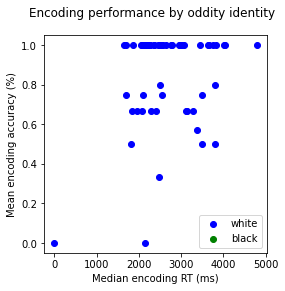

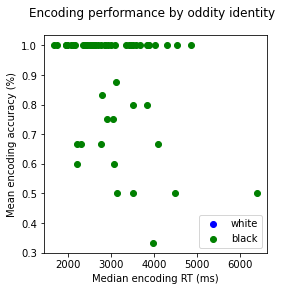

In [106]:
fun.encoding_byface_plot(stats_byface[stats_byface.race=='white'])
fun.encoding_byface_plot(stats_byface[stats_byface.race=='black'])
#fun.encoding_byface_plot(stats_byface)

ValueError: The samples x and y must have the same length.

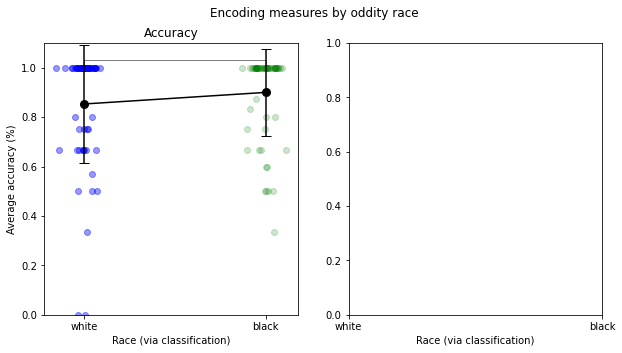

In [107]:
#fun.encoding_byface_plot(stats_byface)
fun.encoding_byface_group_plot(stats_byface)

ValueError: The samples x and y must have the same length.

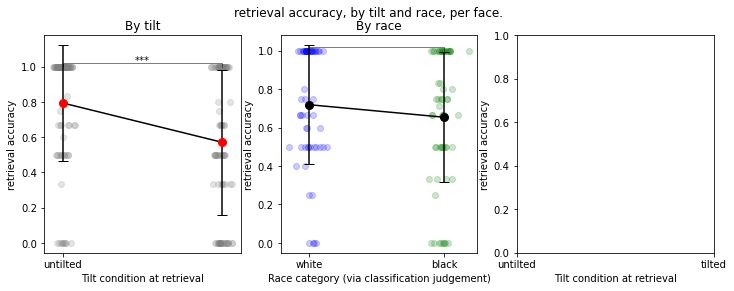

In [108]:
fun.retrieval_byface_plots(stats_byface)
#fun.retrieval_byface_plots(stats_byface, slider=True)

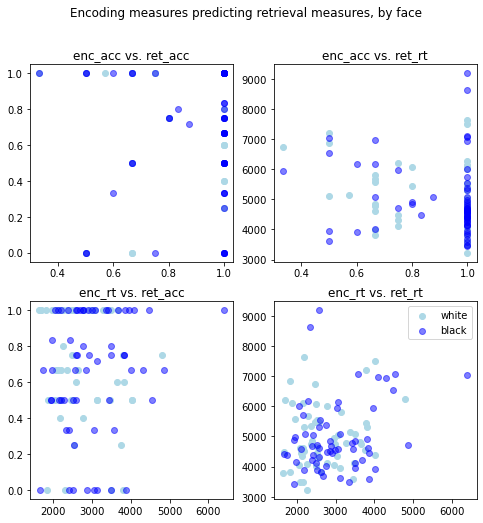

LinregressResult(slope=2.2670976610288124e-06, intercept=0.8704460295683197, rvalue=0.009118134121656492, pvalue=0.9215994038054802, stderr=2.2985463593540216e-05, intercept_stderr=0.06787372295088966)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)


In [109]:
fun.encoding_retrieval_byface_plot(stats_byface)
#fun.encoding_retrieval_byface_plot(mb_resid)
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.enc_acc))
print(sp.linregress(x=stats_byface.enc_acc, y=stats_byface.ret_acc))
print(sp.linregress(x=stats_byface.enc_acc, y=stats_byface.ret_rt))
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.ret_acc))
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.ret_rt))

In [110]:
# interaction between enc_acc and race on ret_acc
w = stats_byface[stats_byface.race=='white']
b = stats_byface[stats_byface.race=='black']
fun.show_model_parameters(smf.ols("ret_acc ~ enc_rt * race", data = {
    'ret_acc': np.concatenate([w.ret_acc, b.ret_acc]),
    'enc_rt': np.concatenate([w.enc_rt, b.enc_rt]),
    'race': np.concatenate([np.repeat(1, len(w)), np.repeat(0, len(b))])
    }))

$\beta = -0.00$, $F(3, 113)$ = $-1.88, P = 0.063 $

### Stimulus attributes

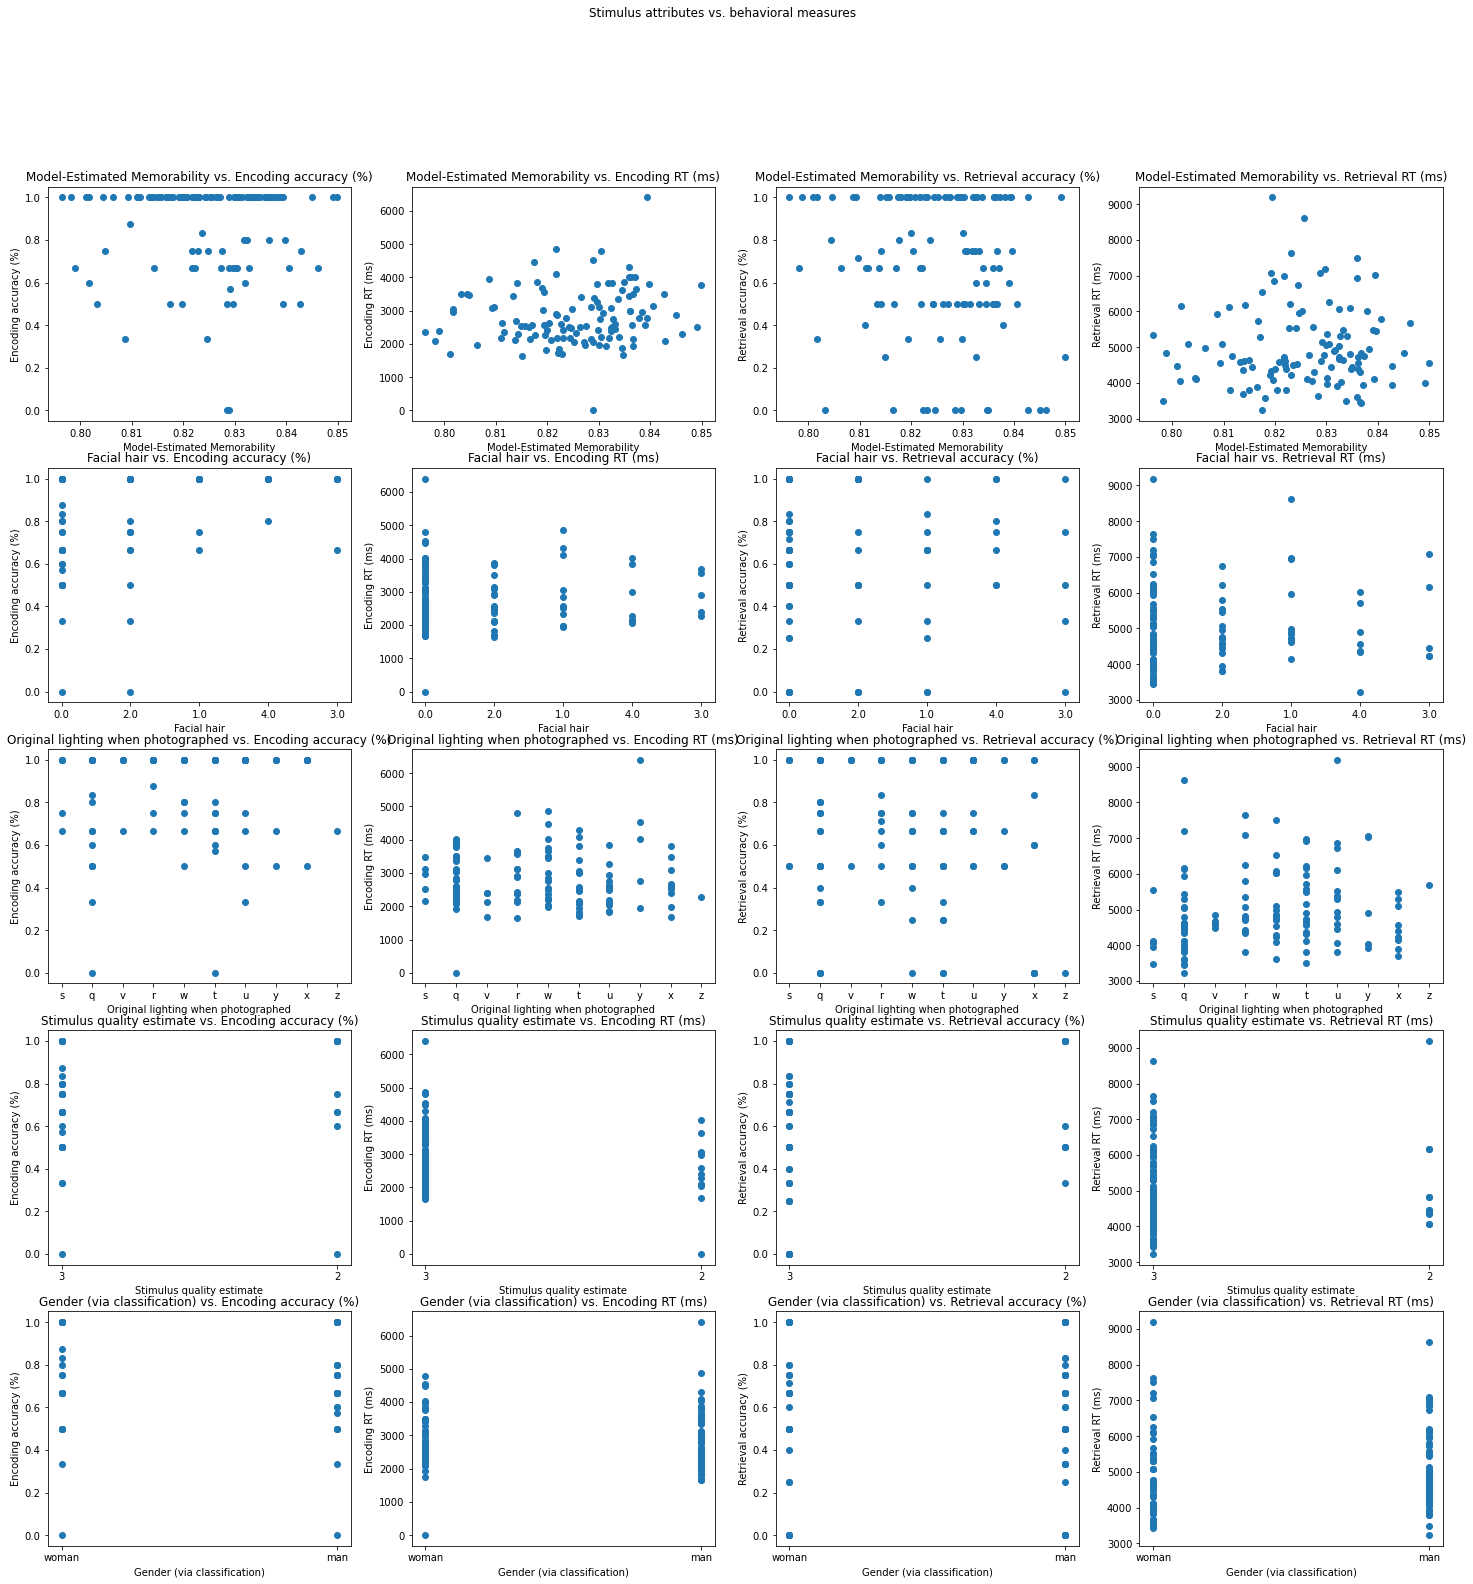

In [111]:
fun.stim_attributes_plot(stats_byface, meta)

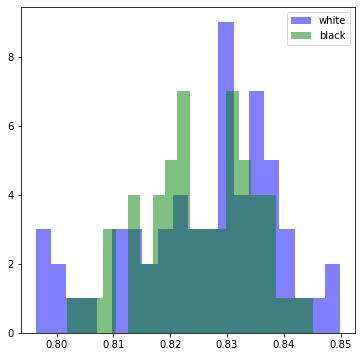

In [112]:
# memorability scores as a function of race
fun.mb_race_plot(meta)

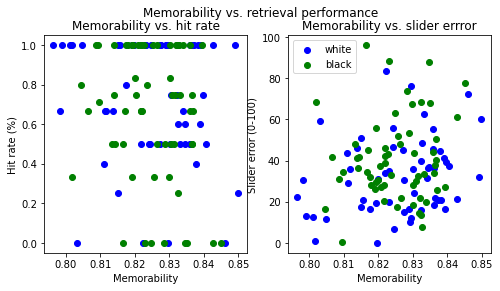

In [113]:
# memorability by race and retrieval accuracy 
# add per image memorability
fun.mb_race_acc_plot(stats_byface, meta)

### Residuals of memorability

In [114]:
mb_resid = stats_byface.copy()
print('R-squared values')
for col in mb_resid.columns:
    if col not in ['identity', 'race', 'gender']: 
        model = smf.ols("target ~ enc_rt", data = {
            "target": stats_byface[col],
            "enc_rt": stats_byface['enc_rt']
        }).fit()
        mb_resid[col] = model.resid
        print(col + ": " + str(model.rsquared))


R-squared values
enc_rt: 1.0
enc_acc: 8.314036986067919e-05
ret_rt: 0.042005285832074746
ret_acc: 2.9335024957499733e-05
ret_rt_0: 0.06453751858563217
ret_acc_0: 0.00016268713804945545
ret_rt_50: 0.00499486216355105
ret_acc_50: 7.607005024667934e-06
ret_dist: 9.998082460338509e-05
ret_dist_0: 0.00045262908501519927
ret_dist_50: 0.0012070394153624875
mb: 0.021479940235899275


ValueError: The samples x and y must have the same length.

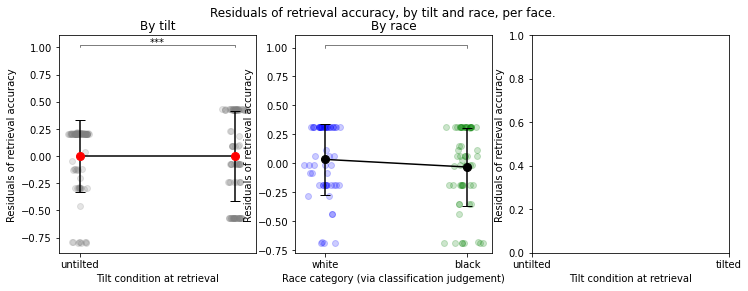

In [115]:
# ignore all but middle plot I think
fun.retrieval_byface_plots(mb_resid, slider = False, mb=True)

In [116]:
fun.ret_tests_byface(mb_resid)

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
$\beta = 0.08$, $F(3, 179)$ = $0.69, P = 0.492 $


In [117]:
enc_mb_resid = stats_byface.copy()
for col in enc_mb_resid.columns:
    if col not in ['identity', 'race', 'gender']: 
        model = smf.ols("target ~ enc_rt * enc_acc * mb", data = {
            "target": stats_byface[col],
            "enc_rt": stats_byface['enc_rt'],
            "enc_acc": stats_byface['enc_acc'],
            "mb": stats_byface['mb']
        }).fit()
        enc_mb_resid[col] = model.resid
        # print(col + ": " + str(model.rsquared))

ValueError: The samples x and y must have the same length.

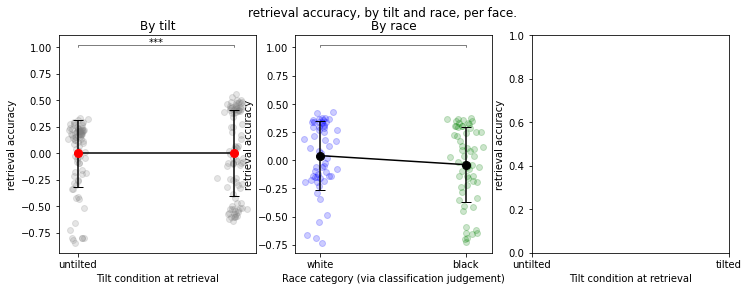

In [118]:
fun.retrieval_byface_plots(enc_mb_resid, slider = False)

In [119]:
fun.ret_tests_byface(enc_mb_resid)

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
$\beta = 0.03$, $F(3, 179)$ = $0.27, P = 0.785 $


### Split half reliability analyses

In [120]:
# of faces, of images, of races, of race-by-tilt (all resolutions)

## New comparisons

### 1. Within-group AFC vs. across-group AFC

In [121]:
# afc_ref = {
#     "pilot_sona_afc2": "across",
#     "pilot_prolific_afc2": "across",
#     "prolific_afc_50_subjects": "across",
    
#     "sona_afc3": "within",
#     "pilot_prolific_afc": "within",
#     "prolific_afc3": "within"
# }
# stats['afc_type'] = [afc_ref[i] for i in stats.iteration]

In [122]:
# wa_data = {
#     'within_white': stats[(stats.afc_type == 'within') & (stats.race.str.contains('White'))],
#     'within_black': stats[(stats.afc_type == 'within') & (stats.race.str.contains('Black'))],
#     'across_white': stats[(stats.afc_type == 'across') & (stats.race.str.contains('White'))],
#     'across_black': stats[(stats.afc_type == 'across') & (stats.race.str.contains('Black'))]
# }
# fun.compare_versions(wa_data)

### 1.5. Pilot_prolific_afc only had 36 trials - does retrieval performance differ?

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

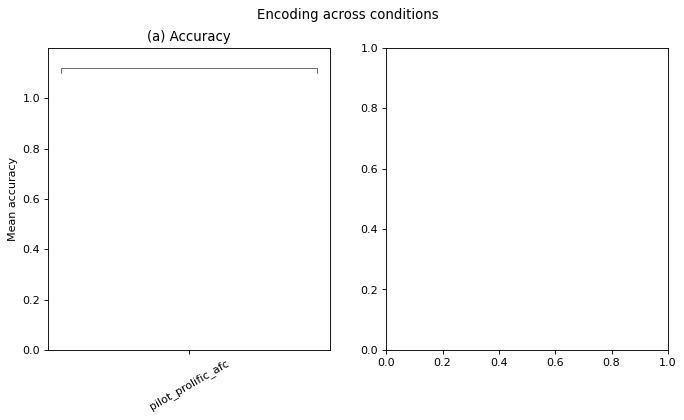

In [123]:
data_help = {
    'pilot_prolific_afc': stats[stats.iteration == 'pilot_prolific_afc'],
    'other': stats[stats.iteration != 'pilot_prolific_afc']
}
fun.compare_versions(data_help)

takeaway: not outside of distribution. if/when it gets to within-subject trial by trial analysis, this may matter more

### 2. White vs. black subs

In [124]:
stats[(stats.afc_type == 'within') & (stats.race.str.contains('White'))]
data_wb = {
    'white': stats[(stats.afc_type == 'within') & (stats.race.str.contains('White'))],
    'black': stats[(stats.afc_type == 'within') & (stats.race.str.contains('Black'))]
}
fun.compare_versions(data_wb)

AttributeError: 'DataFrame' object has no attribute 'afc_type'

takeaway: need to do models with interaction of subj reported race instead of this. but story is less clear than it looked before

### 3. Effect of age

In [125]:
stats['age'] = [df[(df.experiment_id == i) & (df.trial_type == 'demographics')].age.iloc[0] 
                for i in df.experiment_id.unique()]

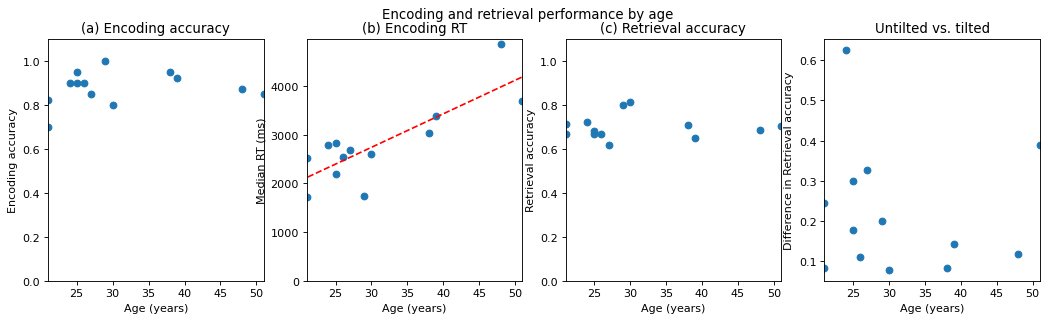

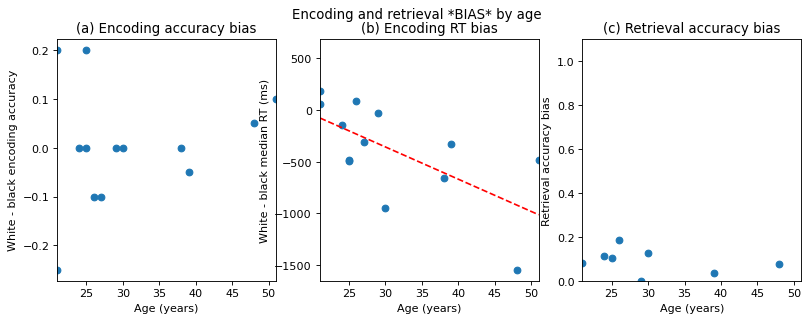

In [126]:
fun.age_plot(stats)
fun.age_bias_plot(stats)

takeaway: no noticeable effect of age here, most importantly on retrieval accuracy. Seems to be some effect on encoding RT but probably not huge or that important?

### 4. Prolific vs. sona

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

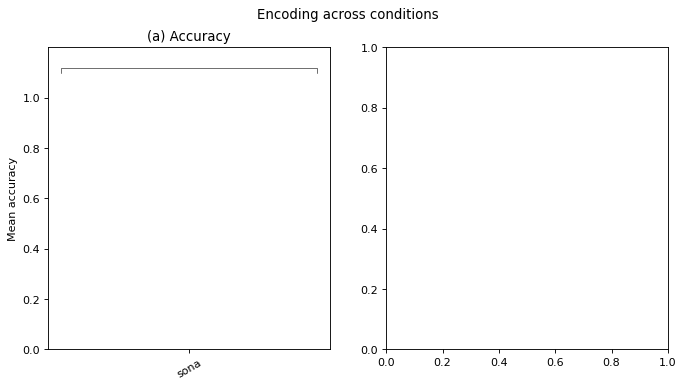

In [127]:
data_help = {
    'sona': stats[stats.iteration.str.contains('sona')],
    'prolific': stats[stats.iteration.str.contains('prolific')]
}
fun.compare_versions(data_help)

takeaway: no evident difference here

### 5. Different encoding splits (median, k=2 clustering etc) on memory performance (instead of subj race)